In [1]:
import pandas as pd
import requests
from matplotlib import pyplot as plt

# Sending a request to the TfL API 
url = "https://api.tfl.gov.uk/AccidentStats/2019"  # Choosing year 2019
response = requests.get(url)

# Downloading the response as a JSON
data = response.json()

# Converting the JSON into a Pandas Dataframe
df = pd.json_normalize(data)
df_init = df.copy()

# Saving the Dataframe as a .csv file
df.to_csv('dataframes/incidenti_tfl_2019.csv', index=False)

/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df.head()

,$type,id,lat,lon,location,date,severity,borough,casualties,vehicles
0,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345979,51.570865,-0.231959,On Edgware Road Near The Junction With north C...,2019-01-04T21:22:00Z,Slight,Barnet,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
1,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345980,51.603859,-0.187240,On Willow Way Near The Junction With Long Lane,2019-01-04T23:33:00Z,Slight,Barnet,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
2,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345981,51.512198,-0.153122,On north Audley Street Near The Junction With ...,2019-01-04T22:15:00Z,Slight,City of Westminster,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
3,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345982,51.431480,-0.016083,On Bromley Road Near The Junction With Daneswo...,2019-01-04T18:00:00Z,Slight,Lewisham,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
4,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345983,51.473487,0.145202,On Belmont Road Near The Junction With Bedonwe...,2019-01-04T20:45:00Z,Slight,Bexley,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...


In [3]:
df.describe()

,id,lat,lon
count,50626.000000,50626.000000,50626.000000
mean,544054.000000,51.509198,-0.118897
std,185715.647807,0.067383,0.141133
min,345828.000000,51.295233,-0.509795
25%,358484.250000,51.468225,-0.200805
50%,544054.000000,51.514006,-0.114336
75%,729623.750000,51.553555,-0.035484
max,742280.000000,51.691126,0.307909


Encode Severity to 0-1-2

In [4]:
df.drop(columns=['$type'], inplace=True)

# converting 'severity' in cardinal indicator
df['severity'] = df['severity'].map({'Slight': 0, 'Serious': 1, 'Fatal': 2})

Encode Borough values to one hot encoding

In [5]:
borough_encoded = pd.get_dummies(df['borough'], prefix='borough', dtype=int)
df = pd.concat([df, borough_encoded], axis=1)
df.drop('borough', axis=1, inplace=True)

Drop Location Column (Unused)

In [6]:
df.drop('location', axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'])

<Axes: ylabel='Frequency'>

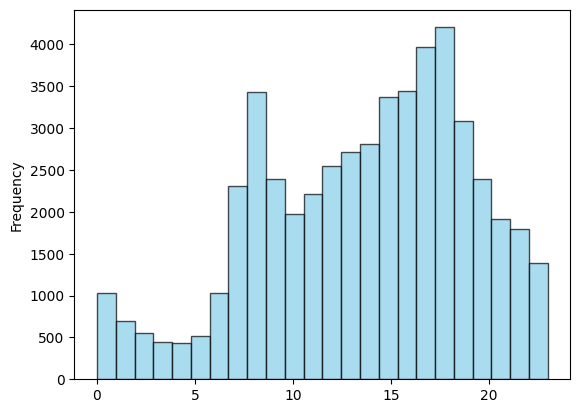

In [7]:
df['date'].dt.hour.plot.hist(bins=24, color='skyblue', edgecolor='black', alpha=0.7)

Encode Vehicles by Category

In [8]:
df_vehicles = df_init.copy()

if df_vehicles['vehicles'].isnull().any():
    print("Warning: Missing or invalid data detected in 'vehicles'. Dropping null values.")
    df_vehicles = df_vehicles.dropna(subset=['vehicles'])

df_vehicles = df_vehicles.explode('vehicles')

df_vehicles.drop(columns=['lat', 'lon', 'date', 'location', 'severity', 'borough', 'casualties'], inplace=True)

df_vehicles_normalized = pd.json_normalize(df_vehicles['vehicles'].values)

if '$type' in df_vehicles_normalized.columns:
    df_vehicles_normalized.drop(columns=['$type'], inplace=True)

df_vehicles = df_vehicles.reset_index(drop=True).join(df_vehicles_normalized)

df_vehicles.drop(columns=['vehicles', '$type'], inplace=True)

df_vehicles.head()


,id,type
0,345979,Motorcycle_500cc_Plus
1,345979,Car
2,345980,Motorcycle_50_125cc
3,345980,Car
4,345980,Car


In [9]:
categories = {
    "Motorcycle": [
        "Motorcycle_0_50cc", "Motorcycle_50_125cc", 
        "Motorcycle_125_500cc", "Motorcycle_500cc_Plus"
    ],
    "Car": [
        "Car", "Taxi", "Minibus", "LightGoodsVehicle"
    ],
    "Heavy_Vehicles": [
        "BusOrCoach", "HeavyGoodsVehicle", "MediumGoodsVehicle", 
        "AgriculturalVehicle"
    ],
    "Pedalcycle": ["PedalCycle"],
    "Other": ["OtherMotorVehicle", "RiddenHorse"]
}

# Map types to categories
category_map = {v: k for k, types in categories.items() for v in types}
df_vehicles['category'] = df_vehicles['type'].map(category_map)

# Count the number of vehicles in each category for each id
category_counts = df_vehicles.groupby(['id', 'category']).size().unstack(fill_value=0)
# Ensure all main categories are represented as columns
for category in categories.keys():
    if category not in category_counts.columns:
        category_counts[category] = 0

# Reset the index to prepare for further analysis
category_counts = category_counts.reset_index()
# category_counts.keys()
df_vehicles = category_counts
df_vehicles.head()
df_vehicles.to_csv('dataframes/vehicles_by_cat.csv', index=False)


Encode Casalties by Category

In [10]:
# Explode the casualties column
df_exploded = df_init.explode('casualties')
# Normalize the casualties field
casualties_df = pd.json_normalize(df_exploded['casualties'])
# Combine the normalized casualties back with the original data
df_exploded = df_exploded.drop(columns=['casualties']).reset_index(drop=True)
df_combined = pd.concat([df_exploded, casualties_df], axis=1)
# Extract ages
ages = casualties_df['age'].dropna().tolist()

# Display results
print("Extracted ages:", ages[:10])  # Display the first 10 ages
print("Lenght of ages: ", len(ages))

Extracted ages: [20.0, 29.0, 48.0, 23.0, 24.0, 18.0, 69.0, 38.0, 42.0, 35.0]
Lenght of ages:  57116


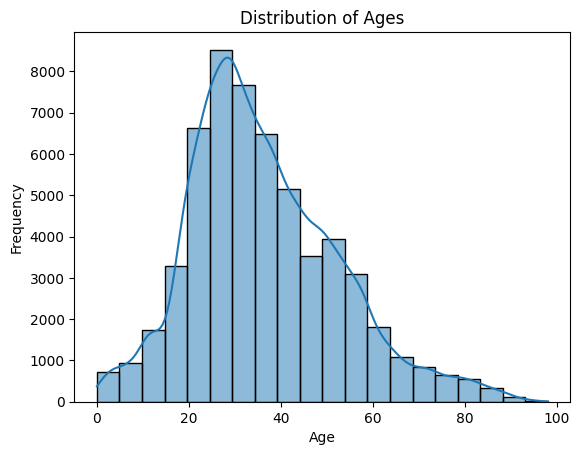

In [11]:
import seaborn as sns
sns.histplot(ages, bins=20, kde=True)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Distribution of Ages")
plt.show()

In [12]:
age_ranges = {
    "0-17": 0,
    "18-25": 0,
    "26-40": 0,
    "41-65": 0,
    "65+": 0
}
for age in ages:
    if age <= 17:
        age_ranges["0-17"] += 1
    elif age <= 25:
        age_ranges["18-25"] += 1
    elif age <= 40:
        age_ranges["26-40"] += 1
    elif age <= 65:
        age_ranges["41-65"] += 1
    else:
        age_ranges["65+"] += 1

print(age_ranges)

{'0-17': 4730, '18-25': 10214, '26-40': 22162, '41-65': 16916, '65+': 3094}


In [13]:
bins, bin_edges = pd.qcut(ages, q=5, labels=["0-23", "24-30", "31-38", "39-50", "50+"], retbins=True)
print("Bin Edges:", bin_edges)
print("Bins:", bins)
print(bins.value_counts())

Bin Edges: [ 0. 23. 30. 38. 50. 98.]
Bins: ['0-23', '24-30', '39-50', '0-23', '24-30', ..., '50+', '50+', '39-50', '31-38', '24-30']
Length: 57116
Categories (5, object): ['0-23' < '24-30' < '31-38' < '39-50' < '50+']
0-23     11764
24-30    11744
31-38    11230
39-50    11648
50+      10730
Name: count, dtype: int64


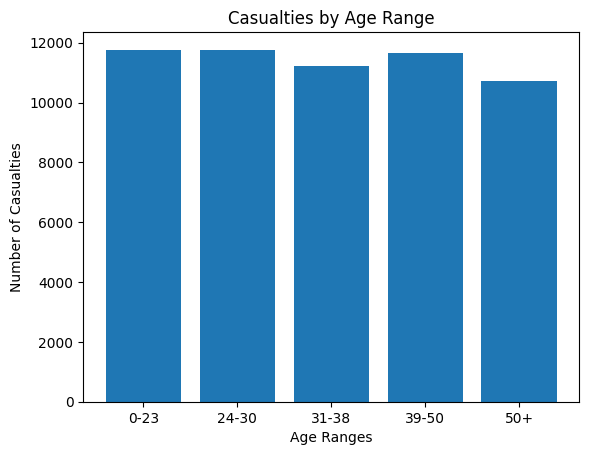

In [14]:
age_ranges = ["0-23", "24-30", "31-38", "39-50", "50+"]
counts = [11764, 11744, 11230, 11648, 10730]

plt.bar(age_ranges, counts)
plt.xlabel("Age Ranges")
plt.ylabel("Number of Casualties")
plt.title("Casualties by Age Range")
plt.show()

In [15]:
# Assume df is your original DataFrame
# Explode the casualties column to work with individual casualties
df_exploded = df_init.explode('casualties')

# Normalize the casualties field to extract age
casualties_df = pd.json_normalize(df_exploded['casualties'])
df_exploded = df_exploded.reset_index(drop=True)
df_combined = pd.concat([df_exploded, casualties_df[['age']]], axis=1)

# Define a function to count casualties in each range
def count_age_ranges(group):
    age_counts = {
        "casualty_age_0-23": sum(group['age'] <= 23),
        "casualty_age_24-30": sum((group['age'] > 23) & (group['age'] <= 30)),
        "casualty_age_31-38": sum((group['age'] > 30) & (group['age'] <= 38)),
        "casualty_age_39-50": sum((group['age'] > 38) & (group['age'] <= 50)),
        "casualty_age_50+": sum(group['age'] > 50)
    }
    return pd.Series(age_counts)

# Group by accident ID and apply the function
age_range_counts = df_combined.groupby('id').apply(count_age_ranges).reset_index()
age_range_counts.head()
age_range_counts.to_csv('dataframes/age_range_counts_to_merge.csv', index=False)
# Merge the counts back to the original DataFrame
# df_with_age_ranges = df.merge(age_range_counts, on='id', how='left')


/var/folders/ng/j8jl9k617sn7s0kcxvhp9ctm0000gn/T/ipykernel_73678/190801574.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_range_counts = df_combined.groupby('id').apply(count_age_ranges).reset_index()


In [16]:
# Time of day Pre Processing 
df['date'] = pd.to_datetime(df['date'])
# df_main['date'].dt.hour.plot.hist(bins=24, color='skyblue', edgecolor='black', alpha=0.7)
df['time_of_day'], bins = pd.cut(df['date'].dt.hour, bins=[0, 6, 12, 18, 24] , labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False, retbins=True)
print(bins)

[ 0  6 12 18 24]


In [17]:
# Encode time_of_day to OHE
time_of_day_encoded = pd.get_dummies(df['time_of_day'], prefix='time_of_day', dtype=int)
df = pd.concat([df, time_of_day_encoded], axis=1)
df.drop('time_of_day', axis=1, inplace=True)

In [18]:
df['month'] = df['date'].dt.month

In [19]:
df['day_of_week'] = df['date'].dt.day_name()
df['day_of_week'] = df['day_of_week'].map({'Monday':0, 'Tuesday':1, 'Wednesday': 2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6})

In [20]:
df_vehicles.head()

category,id,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle
0,345828,2,0,0,0,0
1,345829,2,0,0,0,0
2,345830,1,0,0,0,1
3,345831,1,0,0,0,0
4,345832,2,0,0,0,0


In [21]:
df.drop(["casualties", "vehicles"],axis=1, inplace=True)
df.drop(["date"], axis=1, inplace=True)
df_merged = df.merge(df_vehicles, on='id', how='left')
df_merged = df_merged.merge(age_range_counts, on='id', how='left')
df_merged.head()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345979,51.570865,-0.231959,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
1,345980,51.603859,-0.187240,0,0,1,0,0,0,0,...,2,0,1,0,0,0,1,0,0,0
2,345981,51.512198,-0.153122,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,345982,51.431480,-0.016083,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
4,345983,51.473487,0.145202,0,0,0,1,0,0,0,...,2,0,0,0,0,1,1,0,0,0


In [22]:
df_merged.keys()

Index(['id', 'lat', 'lon', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'month', 'day_of_week', 'Car', 'Heavy_Vehicles',
     

In [23]:
df_merged.describe()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
count,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,...,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000,50626.000000
mean,544054.000000,51.509198,-0.118897,0.154190,0.023940,0.037451,0.018765,0.034014,0.028009,0.036305,...,1.269822,0.080275,0.236519,0.023348,0.193576,0.232371,0.231976,0.221823,0.230079,0.211946
std,185715.647807,0.067383,0.141133,0.374031,0.152865,0.189866,0.135696,0.181267,0.165001,0.187051,...,0.800373,0.279886,0.437951,0.154370,0.405175,0.481610,0.448860,0.431888,0.444623,0.441050
min,345828.000000,51.295233,-0.509795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,358484.250000,51.468225,-0.200805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,544054.000000,51.514006,-0.114336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,729623.750000,51.553555,-0.035484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,742280.000000,51.691126,0.307909,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,3.000000,3.000000,3.000000,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000


In [24]:
df_merged.to_csv('dataframes/final_df.csv', index=False)